In [ ]:
!nvidia-smi

Tue Apr 23 17:50:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers diffusers==0.27.2 lpips accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 33.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [3]:
!pip3 install opencv-python
!pip3 install torch
import cv2
import dlib
import math
import os
import random
import numpy as np
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import PIL

### **FACE DETECTION**

In [4]:
global detected_face_shape
detected_face_shape = None

In [5]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [6]:
# Load facial landmark detection model
p = "/content/drive/MyDrive/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(p)

In [7]:
# Utility functions to calculate distance and ratios:
def euclidean_distance(point1, point2):
    return math.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)

def forehead_width(landmarks):
    return euclidean_distance((landmarks.part(2).x, landmarks.part(2).y), (landmarks.part(21).x, landmarks.part(21).y))

def face_width(landmarks):
    return max(jawline_length(landmarks), forehead_width(landmarks))

def face_height(landmarks):
    return euclidean_distance((landmarks.part(1).x, landmarks.part(1).y), (landmarks.part(15).x, landmarks.part(15).y))

def jawline_length(landmarks):
    return euclidean_distance((landmarks.part(0).x, landmarks.part(0).y), (landmarks.part(16).x, landmarks.part(16).y))

def cheekbone_length(landmarks):
    return euclidean_distance((landmarks.part(10).x, landmarks.part(10).y), (landmarks.part(15).x, landmarks.part(15).y))

def ear_length(landmarks):
    return euclidean_distance((landmarks.part(4).x, landmarks.part(4).y), (landmarks.part(18).x, landmarks.part(18).y))

def interocular_distance(landmarks):
    return euclidean_distance((landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(41).x, landmarks.part(41).y))

def eye_width(landmarks):
    return interocular_distance(landmarks) * 0.5

def jaw_width_to_height_ratio(landmarks):return jawline_length(landmarks) / face_height(landmarks)

def cheekbones_to_ear_ratio(landmarks):
    return cheekbone_length(landmarks) / ear_length(landmarks)

In [8]:
# Calculate_shape function : landmarks
def calculate_shape(landmarks):
    global detected_face_shape

    if 0.85 <= jaw_width_to_height_ratio(landmarks) <= 1.15 and 0.95 <= cheekbones_to_ear_ratio(landmarks) <= 1.05:
        detected_face_shape = 'Round'

    elif 0.95 <= jaw_width_to_height_ratio(landmarks) <= 1.05 and abs(face_width(landmarks) - face_height(landmarks)) < 0.1 * face_height(landmarks):
        detected_face_shape = 'Square'

    elif 1.25 <= cheekbones_to_ear_ratio(landmarks) <= 1.35 and forehead_width(landmarks) / face_width(landmarks) < 0.45 and jawline_length(landmarks) / face_width(landmarks) > 0.55:
        detected_face_shape = 'Diamond'

    else:
        detected_face_shape = 'Unknown'


In [9]:
def detect_faces(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face = gray_frame[y:y+h, x:x+w]
        landmarks = predictor(face, dlib.rectangle(0, 0, w, h))
        shape = calculate_shape(landmarks)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, detected_face_shape, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return frame

def landmarks_for_face(face):
    return predictor(face, dlib.rectangle(left=0, top=0, right=face.shape[1], bottom=face.shape[0]))

In [10]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [11]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


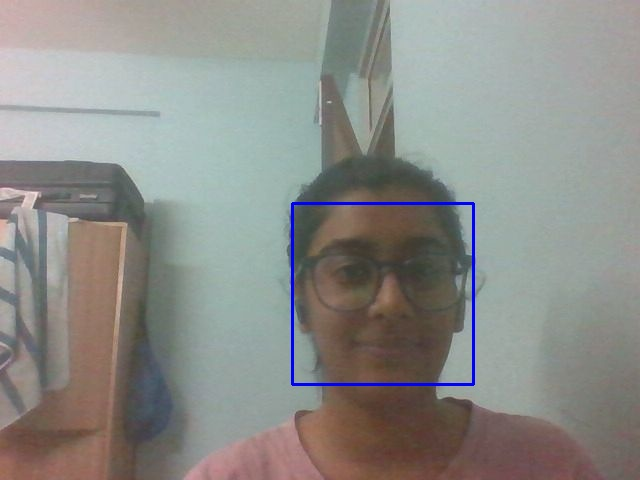

In [12]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [13]:
frame = cv2.imread('photo.jpg')

# Initialize the detected_face_shape variable
detected_face_shape = None

# Process frame
frame = detect_faces(frame)

# Display the frame
#cv2.imshow('Face Shapes', frame)
cv2.waitKey(0)


# Check if a face shape is detected
if detected_face_shape is not None:
    # Display the detected face shape
    cv2.putText(frame, detected_face_shape, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # print(f"Detected face shape: {detected_face_shape}")


# Print the detected face shape
print(f"Detected face shape: {detected_face_shape}")
print("Image processed.")


Detected face shape: Square
Image processed.


selected jewel MAHTAB Necklace.png


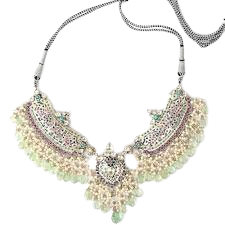

In [25]:
if detected_face_shape is not None:
    # # Define dataset path and shapes folder
    dataset_path = "/content/drive/MyDrive/Jewels_dataset"
    d_face_shape = detected_face_shape
    shapes_folder = os.path.join(dataset_path, d_face_shape)
    # print("shapes folder",shapes_folder)

    # Check if the shape folder exists
    if not os.path.exists(shapes_folder):
        print(f"The '{d_face_shape}' folder does not exist in the dataset.")
        exit()

    jewelry_items=[]
    for images in os.listdir(shapes_folder):

        # check if the image ends with png or jpg or jpeg
        if (images.endswith(".png") or images.endswith(".jpg")\
            or images.endswith(".jpeg")):
            # display
            jewelry_items.append(images)

    # print("jewelery",jewelry_items)

    # # Select a random jewelry item
    selected_jewel = random.choice(jewelry_items)
    print("selected jewel",selected_jewel)
    image_path= os.path.join(shapes_folder,selected_jewel)
    display(Image(filename=image_path))


    if not selected_jewel:
        print(f"No jewelry items available in the '{d_face_shape}/{selected_jewel}' folder.")
        exit()

In [15]:
from diffusers import StableDiffusionPipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [26]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
prompt = f"a woman with {detected_face_shape} wearing {selected_jewel}"

In [28]:
pipe = pipe.to("cuda")

In [29]:
image = pipe(prompt).images[0]


  0%|          | 0/50 [00:00<?, ?it/s]

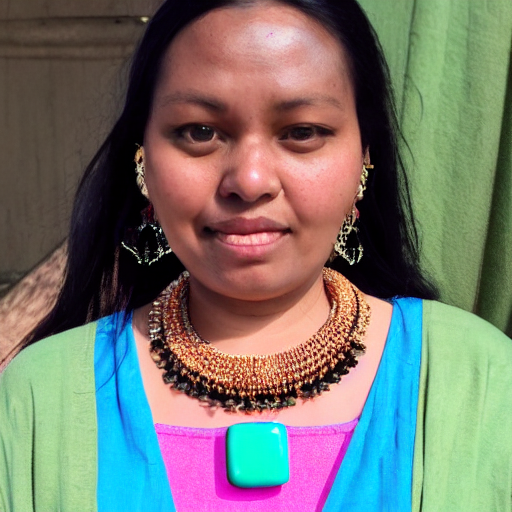

In [30]:
image